In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical



def tanh_derivative(x):
    return 1 - np.square(x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def linear(x):
    return x

def linear_derivative(x):
    return np.ones_like(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)


def ini_weights_zeros(input_size, output_size):
    return np.zeros((input_size, output_size))

def ini_weights_random(input_size, output_size):
    return np.random.rand(input_size, output_size)

def ini_weights_normal(input_size, output_size):
    return np.random.normal(0, 1, (input_size, output_size))


def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh(x):
    return np.tanh(x)





class NeuralNetwork:
    def __init__(self, N, layer_sizes, lr, activation_fn, weight_init_fn, num_epochs, batch_size):
        self.N = N

        self.layer_sizes = layer_sizes
        self.lr = lr

        self.activation_fn = activation_fn
        self.weight_init_fn = weight_init_fn

        self.num_epochs = num_epochs
        self.batch_size = batch_size

        self.weights = []
        self.biases = []

        self.activations = []
        self.losses = []

    def initialize_weights(self, input_size, output_size):
        if self.weight_init_fn == "zero":
            return ini_weights_zeros(input_size, output_size)
        elif self.weight_init_fn == "random":
            return ini_weights_random(input_size, output_size)
        elif self.weight_init_fn == "normal":
            return ini_weights_normal(input_size, output_size)

    def initialize_activation_functions(self):
        self.activation_functions = [self.activation_fn] * (self.N - 1) + [softmax]
        self.activation_derivatives = [sigmoid_derivative, tanh_derivative, relu_derivative,
                                      leaky_relu_derivative, linear_derivative]

    def forward_pass(self, X):
        self.activations = []
        input_data = X
        self.activations.append(input_data)

        for i in range(self.N - 1):
            z = np.dot(input_data, self.weights[i]) + self.biases[i]
            activation = self.activation_functions[i](z)
            self.activations.append(activation)
            input_data = activation

        return input_data

    def backward_pass(self, X, Y, predictions):
        errors = Y - predictions
        delta = errors

        for i in range(self.N - 2, -1, -1):
            gradient = self.activation_derivatives[i](self.activations[i + 1])
            delta = delta * gradient
            self.weights[i] += self.lr * np.dot(self.activations[i].T, delta)
            self.biases[i] += self.lr * np.sum(delta, axis=0, keepdims=True)
            delta = np.dot(delta, self.weights[i].T)

    def fit(self, X, Y, X_val, Y_val):
        self.initialize_activation_functions()

        for epoch in range(self.num_epochs):
            for i in range(0, X.shape[0], self.batch_size):
                batch_X = X[i:i + self.batch_size]
                batch_Y = Y[i:i + self.batch_size]

                predictions = self.forward_pass(batch_X)
                self.backward_pass(batch_X, batch_Y, predictions)

            # Validation loss calculation
            val_predictions = self.forward_pass(X_val)
            val_loss = -np.mean(Y_val * np.log(val_predictions + 1e-8))
            self.losses.append(val_loss)
            print(f"Epoch: {epoch + 1}/{self.num_epochs}, Validation Loss: {val_loss:.4f}")

    def predict_proba(self, X):
        return self.forward_pass(X)

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    def score(self, X, Y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == np.argmax(Y, axis=1))
        return accuracy




def load_and_preprocess_mnist():
    (X_train, y_train), (X_val, y_val) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    X_val = X_val.reshape(X_val.shape[0], -1) / 255.0

    y_train = to_categorical(y_train, num_classes=10)
    y_val = to_categorical(y_val, num_classes=10)

    return X_train, y_train, X_val, y_val




def train_and_plot(X_train, y_train, X_val, y_val, layer_sizes, lr, activation_fn, weight_init_fn, num_epochs, batch_size):
    model = NeuralNetwork(len(layer_sizes), layer_sizes, lr, activation_fn, weight_init_fn, num_epochs, batch_size)
    model.fit(X_train, y_train, X_val, y_val)


    plt.plot(range(num_epochs), model.losses, label=activation_fn.__name__)
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.show()



if __name__ == "__main__":
    X_train, y_train, X_val, y_val = load_and_preprocess_mnist()


    hidden_layers = 4
    layer_sizes = [256, 128, 64, 32]
    epochs = 100
    batch_size = 128


    activation_functions = [tanh, relu, leaky_relu, linear]

    for activation_fn in activation_functions:
        train_and_plot(X_train, y_train, X_val, y_val, layer_sizes, lr=0.01, activation_fn=activation_fn, weight_init_fn="random", num_epochs=epochs, batch_size=batch_size)


In [ ]:
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import numpy as np
import random




def load_data():
    url = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
    file_path = "train_32x32.mat"
    urllib.request.urlretrieve(url, file_path)

    # Assuming you have loaded the dataset into X and y
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test


def load_data_file(file_path):
    names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
    data = pd.read_csv(file_path, names=names)
    return data

def load_data():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
    names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
    data = pd.read_csv(url, names=names)
    return data


def handle_missing_values(data):
    data = data.replace('?', pd.NA)
    data = data.apply(pd.to_numeric, errors='coerce')
    data.fillna(data.mean(), inplace=True)  # Filling missing values with mean
    return data


def preprocess_data(data):
    data = pd.get_dummies(data, columns=['cp', 'restecg', 'slope', 'thal'])
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.drop('num', axis=1))
    data = pd.DataFrame(scaled_data, columns=data.columns[:-1])
    data['num'] = data['num'].astype(int)
    return data

def visualize_data(data):
    sns.pairplot(data, hue='num')
    plt.title('Pairplot for the Dataset')
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

def visualize_class_distribution(y_train):
    plt.figure(figsize=(12, 6))
    sns.countplot(y_train)
    plt.title("Distribution of Class Labels in Training Set")
    plt.show()

def visualize_samples(X_train, y_train):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        index = random.randint(0, len(X_train))
        plt.subplot(1, 5, i+1)
        plt.imshow(X_train[index])
        plt.title(f"Class: {y_train[index]}")
        plt.axis('off')
    plt.show()

def train_model(X_train, y_train):
    model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100)

    param_grid = {
        'hidden_layer_sizes': [(100, 50), (150, 100), (50,)],
        'activation': ['relu', 'tanh', 'logistic', 'identity'],
        'solver': ['adam', 'sgd'],
        'batch_size': [32, 64, 128],
    }

    grid_search = GridSearchCV(model, param_grid, cv=3)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    activations = ['relu', 'tanh', 'logistic', 'identity']
    models = {}

    for activation in activations:
        model = MLPClassifier(hidden_layer_sizes=(100, 50), activation=activation, max_iter=100)
        model.fit(X_train, y_train)
        models[activation] = model

    return models, best_params

def plot_training_loss(models):
    plt.figure(figsize=(10, 6))
    for activation, model in models.items():
        plt.plot(model.loss_curve_, label=activation)

    plt.title("Training Loss vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.legend()
    plt.show()

def evaluate_best_model(models, best_params, X_test, y_test):
    best_model = models[best_params['activation']]
    accuracy = best_model.score(X_test, y_test)
    print(f"Best Accuracy on Test Set: {accuracy}")

def visualize_incorrect_predictions(X_test, y_test, best_model):
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(15, 10))

    for i in range(len(conf_matrix)):
        misclassified_indices = np.where((y_test != y_pred) & (y_test == i))[0][:3]
        for j, index in enumerate(misclassified_indices):
            plt.subplot(len(conf_matrix), 3, i*3 + j + 1)
            plt.imshow(X_test[index])
            plt.title(f"True: {y_test[index]}, Predicted: {y_pred[index]}")
            plt.axis('off')

    plt.show()

def main():
    X_train, y_train, X_val, y_val, X_test, y_test = load_data()

    visualize_class_distribution(y_train)
    visualize_samples(X_train, y_train)

    models, best_params = train_model(X_train, y_train)
    plot_training_loss(models)
    analyze_model_effectiveness(models)
    evaluate_best_model(models, best_params, X_test, y_test)
    visualize_incorrect_predictions(X_test, y_test, models[best_params['activation']])

if __name__ == "__main__":
    main()


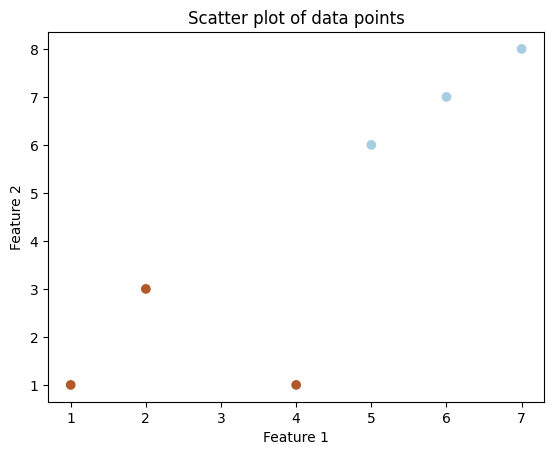

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Given data
data_points = np.array([(2, 3), (6, 7), (5, 6), (4, 1), (1, 1), (7, 8)])
labels = np.array([1, -1, -1, 1, 1, -1])

# Plotting the points
plt.scatter(data_points[:, 0], data_points[:, 1], c=labels, cmap=plt.cm.Paired, marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter plot of data points')
plt.show()
